## 第十一週：主題模型（中文）
**Autor**: 張芳瑜 <br>
**Date created**: 2021/09/27 <br>
**Last modified**: 2021/10/07

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為四個部分：1.介紹使用到的套件 2.將資料進行前處理 3.建立LDA模型 4.視覺化主題模型


## 大綱
1. 套件說明
1. 資料前處理
    + 2.1 資料描述
    + 2.2 Jieba中文斷詞、匯入字典
    + 2.3 去除停用字
1. LDA 主題模型
    + 3.1 訓練LDA模型
    + 3.2 查看 LDA 主題代表字
    + 3.3 查看 LDA 模型指標
    + 3.4 透過指標找出最佳主題數
1. 視覺化呈現
    + 4.1 產生 LDAvis 結果
    + 4.2 查看 Document 主題時間上分佈

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ pandas:提供高效能、簡易使用的資料格式與資料處理的函數。
+ jieba:中文斷詞套件
+ re:正規化表達式套件
+ matplotlib:繪圖工具
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [35]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

In [2]:
# 設定圖的字體大小
font = {'size':14}
matplotlib.rc('font', **font)

In [3]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. 資料前處理
根據文字處理基本流程，我們需要將我們的資料進行資料前處理。
+ 資料收集：通常我們使用網路爬蟲技術來取得資料（網路爬蟲非本課程之目的），因此在此範例中，我們使用中山管院文字分析平台，來收集文本資料。
+ 資料清理：將文本內容轉為正規語句，例如：統一標點符號、去除特定標籤等等。
+ 斷詞、斷句：使用工具區分文章中的句子、詞彙，以便於進行分析。
+ 去除停用字：將與分析無關的詞彙去除，例如：語助詞、連接詞等等，來避免影響後續分析結果。

**2.1 資料描述**
+ 來源：聯合新聞網、蘋果新聞網、東森新聞網（中山管院文字分析平台）
+ 時間：2020/10/01 到 2021/05/09，隨機選1000篇新聞。
+ 搜尋關鍵字：疫苗

In [4]:
# 匯入資料
data = pd.read_csv('./raw_data/news_articleMetaData.csv', encoding='UTF-8')
metadata = data.sample(n=1000, random_state=2021).reset_index(drop=True)

**查看「疫苗」的相關報導在時間上的數量走勢** <br>
+ 將資料中「artDate」(報導日期)groupby起來，並計算數量。
+ 日期資料轉換為日期格式，之後圖示會幫助閱讀。

In [5]:
# groupby artDate 轉為新的DataFrame
day_count = pd.DataFrame({
    'date': metadata.groupby('artDate').size().index,
    'count': metadata.groupby('artDate').size().values
})
day_count = day_count.sort_values(by='date') # 排序
day_count.date = pd.to_datetime(day_count['date']) # 將裡面資料轉為日期格式

+ 觀察折線圖，可以發現疫苗的相關報導在2月過後數量有增加的趨勢。
+ 在三月中旬數量達到高峰，四月後逐漸減少

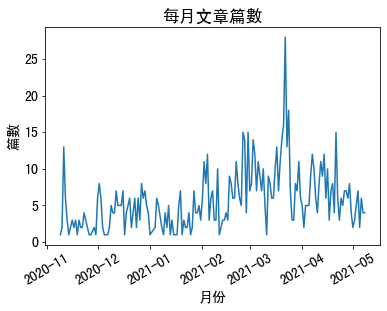

In [6]:
plt.plot(day_count['date'], day_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

**2.2 Jieba中文斷詞、匯入字典**

斷詞引擎設定：使用 Jieba 當作斷詞系統。<br>

Jieba 原先內建為簡體字字典，因此我們匯入繁體字典，斷詞結果會比較好。<br>
另外，在一些特殊主題裡，會有獨特的專有名詞，因此我們需要加入這些字詞進去。<br>
兩種方式：1.匯入檔案 2.參數形式手動加入

以下用匯入檔案的方式：

In [7]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
jieba.set_dictionary('./dict/dict.txt') 

# 自定義辭典
print("--> 匯入自定義字典，這裡匯入疫苗的名稱")
jieba.load_userdict('./dict/user_dict.txt')


Building prefix dict from /Users/changfangyu/Desktop/NSYSU/碩班/110 社群媒體/code/SMA_2021F/week12_topic_model/dict/dict.txt ...


--> 匯入自定義字典，這裡匯入疫苗的名稱


Dumping model to file cache /var/folders/yw/v6fz89fx5pd827bs1070ywr00000gn/T/jieba.uc85171de1e540c6b3e7b255b0701718a.cache
Loading model cost 0.502 seconds.
Prefix dict has been built successfully.


拿取資料裡 url(連結)、sentence(文章)，並將文章內容進行斷詞

In [8]:
# 資料進行斷詞，為list的格式
data = metadata[['artUrl','sentence']]
token_df = data.assign(wordlist = data['sentence'].apply(jieba.lcut))

print("資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)")
token_df.head(3)

資料斷詞後的 DataFrame：artUrl(連結)、sentence(文章)、wordlist(斷詞)


,artUrl,sentence,wordlist
0,https://tw.appledaily.com/international/202103...,美國總統拜登11日在簽署1.9兆美元紓困後發表上任後首次的黃金時段演說，他表示會下令各州在5...,"[美國, 總統, 拜登, 11, 日, 在, 簽署, 1.9, 兆, 美元, 紓困, 後, ..."
1,https://udn.com/news/story/120940/5343188,國內3月22日開打AZ疫苗後，傳出北部某醫學中心一名40多歲護理師，接種AZ疫苗後出現急性過...,"[國內, 3, 月, 22, 日, 開打, AZ, 疫苗, 後, ，, 傳出, 北部, 某,..."
2,https://udn.com/news/story/120944/5055649,俄羅斯新聞社（RIA）今天引述聯邦消費者權益保護暨福利監督署的說法報導，俄羅斯計劃從今天起對...,"[俄羅斯, 新聞社, （, RIA, ）, 今天, 引述, 聯邦, 消費者, 權益, 保護,..."


**2.3 去除停用字**

為了提高準確度，我們會將停用字移除，例如：空格、標點符號、語助詞...等。<br>
兩種方式： 1.匯入檔案 2.參數形式手動加入

以下使用匯入檔案的方式：

In [9]:
stopwords = []

#匯入檔案
with open(f'./dict/stopwords.txt','r') as f:
    stopwords = f.read().splitlines() #移除換行符號\n

print("stropwords儲存為list形式，前幾個為：")
stopwords[:15]

stropwords儲存為list形式，前幾個為：


['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

除了移除停用字，也可以設定其他條件。
+ 字的長度要大於一
+ 只選沒有在停用字點裡的字
+ 用正規表達式移除，舉例：\d 移除數字

In [10]:
# 移除停用字的 function
def remove_stop(listt):
    result = [re.sub(r'\d|-', '', word) for word in listt]
    result = [word for word in result if len(word)>1] 
    result = list(filter(lambda x : x not in stopwords, result)) 
    return result

In [11]:
# list 刪掉 stopwords
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove_stop))
print("remove_stopwords 為 wordlist 移除停用字後的結果：")
token_df.head(3)

remove_stopwords 為 wordlist 移除停用字後的結果：


,artUrl,sentence,wordlist,remove_stopwords
0,https://tw.appledaily.com/international/202103...,美國總統拜登11日在簽署1.9兆美元紓困後發表上任後首次的黃金時段演說，他表示會下令各州在5...,"[美國, 總統, 拜登, 11, 日, 在, 簽署, 1.9, 兆, 美元, 紓困, 後, ...","[美國, 總統, 拜登, 簽署, 美元, 紓困, 發表, 上任, 首次, 黃金, 時段, 演..."
1,https://udn.com/news/story/120940/5343188,國內3月22日開打AZ疫苗後，傳出北部某醫學中心一名40多歲護理師，接種AZ疫苗後出現急性過...,"[國內, 3, 月, 22, 日, 開打, AZ, 疫苗, 後, ，, 傳出, 北部, 某,...","[國內, 開打, AZ, 疫苗, 傳出, 北部, 醫學, 中心, 一名, 多歲, 護理師, ..."
2,https://udn.com/news/story/120944/5055649,俄羅斯新聞社（RIA）今天引述聯邦消費者權益保護暨福利監督署的說法報導，俄羅斯計劃從今天起對...,"[俄羅斯, 新聞社, （, RIA, ）, 今天, 引述, 聯邦, 消費者, 權益, 保護,...","[俄羅斯, 新聞社, RIA, 今天, 引述, 聯邦, 消費者, 權益, 保護, 福利, 監..."


## 3. LDA 主題模型

Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**3.1 訓練 LDA 模型**

將文章斷詞結果儲存為 list 資料形態，一篇文章為一個 list ，其中 element 為詞彙。

In [12]:
token_data = token_df['remove_stopwords'].tolist()

In [13]:
for i in range(0,3):
    print("第 " + str(i+1) + " 篇文章前10個字：")
    for j in range(0,10):
        print(token_data[i][j], end=' ')
    print('\n')

第 1 篇文章前10個字：
美國 總統 拜登 簽署 美元 紓困 發表 上任 首次 黃金 

第 2 篇文章前10個字：
國內 開打 AZ 疫苗 傳出 北部 醫學 中心 一名 多歲 

第 3 篇文章前10個字：
俄羅斯 新聞社 RIA 今天 引述 聯邦 消費者 權益 保護 福利 



id2word 將斷詞結果生成字典，裡頭為資料集裡出現的字。

In [14]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(19236 unique tokens: ['COVID', '一再', '一同', '一次', '一般人']...)


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[0]:[(0, 1), (1, 1), (2, 3), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'COVID-'出現一次'、'一再'出現一次、'一同'出現三次...以此類推

In [15]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1)]


參數說明：
+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [16]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=1005, # 亂數
    iterations = 1000,
    passes=5, # 模型訓練次數
)

**3.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
(0, '0.017*"疫苗" + 0.007*"委員會" + 0.006*"採購" ... )<br>
-> 第一個主題的詞彙分佈，0.017:疫苗、0.007:委員會、0.006:採購...（全部詞彙加起來會等於一）

In [17]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.017*"疫苗" + 0.007*"委員會" + 0.006*"採購" + 0.005*"接種" + 0.005*"調閱"')
(1, '0.058*"疫苗" + 0.027*"接種" + 0.012*"施打" + 0.009*"表示" + 0.009*"AZ"')
(2, '0.059*"疫苗" + 0.011*"接種" + 0.010*"病毒" + 0.009*"中國" + 0.008*"表示"')
(3, '0.043*"疫苗" + 0.011*"疫情" + 0.008*"接種" + 0.008*"試驗" + 0.008*"表示"')


我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：委員會討論「疫苗採購調閱專案小組」相關報導
+ 主題二：AZ 疫苗施打
+ 主題三：中國疫苗接種
+ 主題四：疫苗接種臨床試驗相關報導

**3.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [18]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  0.020259414917299864


In [19]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -7.768912082028235


**3.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 4 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [86]:
topic_num_list = np.arange(2, 10, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})

,topic_num,gensim_perplexity,perplexity
0,2,-7.780650,2393.830980
1,4,-7.763410,2352.914884
2,6,-7.762037,2349.685971
3,8,-7.769332,2366.889543


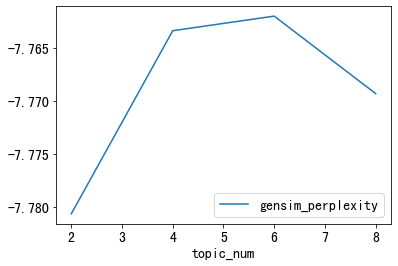

In [87]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.780650,2393.830980
1,4,-7.763410,2352.914884
2,6,-7.762037,2349.685971
3,8,-7.769332,2366.889543


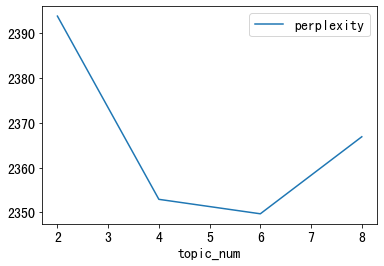

In [88]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

## 4. 視覺化呈現

**4.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例，較方便解釋

In [102]:
#生成模型 
ldamodel2 = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, 
    id2word=id2word, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2500, # 亂數
    iterations = 2000,
    passes=5, # 模型訓練次數
)
# 1分鐘內跑完

In [104]:
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis.html')

**4.2 查看 Document 主題時間上分佈**

使用模型分析我們的資料，取得每條新聞的主題分佈，選最大的設為此文章的主題。<br>
再根據時間來做分析，了解不同的時間點討論的主題大多為什麽，以比例的方式呈現。

In [105]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    doc_list.append(max_topic)

In [106]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [107]:
# 將 artDate 轉換為 Python 日期時間
metadata.artDate = pd.to_datetime(metadata['artDate'])

In [108]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
# date_topic.artDate.dt.to_period('M')：把日期按月份形式表示
date_topic = date_topic.groupby([date_topic.artDate.dt.to_period('M'),'topic']).sum().reset_index()


In [109]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2', 'topic3']
# 前面日期變period形式要把他變回timestamp形式 --> to_timestamp：以便於畫圖
date_df = date_df.set_index('artDate').to_timestamp()
date_df

,topic0,topic1,topic2,topic3
artDate,,,,
2020-11-01,2.0,6.0,35.0,13.0
2020-12-01,1.0,36.0,74.0,21.0
2021-01-01,1.0,9.0,41.0,33.0
2021-02-01,1.0,72.0,94.0,25.0
2021-03-01,20.0,183.0,73.0,19.0
2021-04-01,8.0,136.0,44.0,20.0
2021-05-01,0.0,14.0,11.0,8.0


可以看到在不同時間點，特定主題談論篇幅的多寡

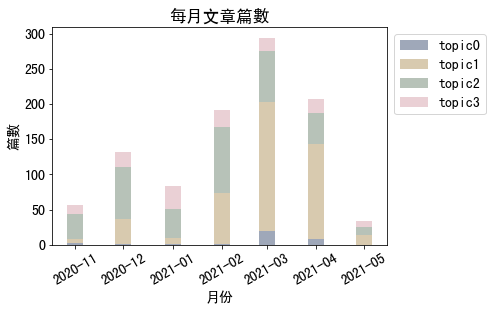

In [110]:
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5"]
column = ['topic0', 'topic1', 'topic2', 'topic3']
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + date_df[column[i-1]]
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=10)
    else: # 主題一 bottom 為 0
        plt.bar(date_df.index, date_df[column[i]] ,color=color[i], label=column[i] , width=10)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

我們也可以將它轉換為比例來看

In [111]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3

for i in range(0,4):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,topic3,sum
artDate,,,,,
2020-11-01,0.035714,0.107143,0.625000,0.232143,56.0
2020-12-01,0.007576,0.272727,0.560606,0.159091,132.0
2021-01-01,0.011905,0.107143,0.488095,0.392857,84.0
2021-02-01,0.005208,0.375000,0.489583,0.130208,192.0
2021-03-01,0.067797,0.620339,0.247458,0.064407,295.0
2021-04-01,0.038462,0.653846,0.211538,0.096154,208.0
2021-05-01,0.000000,0.424242,0.333333,0.242424,33.0


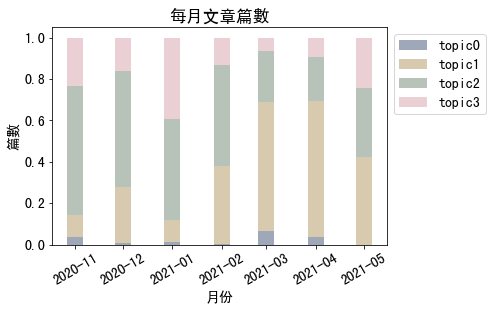

In [112]:
temp_bottom = 0

for i in range(0,4):
    if(i>0):
        temp_bottom = temp_bottom + ratio_df[column[i-1]]
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i], width=10)
    else: # 主題一 bottom 為 0
        plt.bar(ratio_df.index, ratio_df[column[i]] ,color=color[i], label=column[i], width=10)

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

可以根據上面的圖表，搭配時事推估，例如：
+ topic2 前面的比例較高，後面漸漸變少，推估應該是那時候在爭少是否引進中國新冠疫苗
+ topic0 跟其他主題相較起來篇幅最少，推測當時相關新聞應該為少數
+ topic1 則是在後期篇幅變多，推測應該是 AZ疫苗開始施打而開始有大篇幅的報導
+ topic3 在一月的時候有大篇幅的增加，推估可能是因為公費疫苗擴大提供全民接種

除此之外，我們也可以隨機看一下不同主題大概在談論什麼，是否符合預測。

In [113]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
898,成立疫苗採購調閱小組 陳玉珍蘇巧慧衛環委員會互嗆,2021-03-22,09:57:00,https://udn.com/news/story/120940/5334365,國內首批AZ新冠肺炎疫苗今天開打。立法院衛環委員會國民黨籍召委陳玉珍上周臨時提案成立「疫苗採...,0
717,打完疫苗「性慾爆發」！85歲翁1hr戰3妹 警大笑罰錢了｜東森新聞,2021-04-27,00:00:00,https://news.ebc.net.tw/news/article/258660,新冠疫情持續在全球延燒，各國也紛紛開打新冠疫苗，不過卻也陸續傳出有副作用發生的狀況，近日就有...,0
393,艾爾段：本土新冠肺炎疫苗2021年4月前問世,2020-11-25,21:19:00,https://udn.com/news/story/120944/5043742,土耳其總統艾爾段今天表示，本土新冠肺炎疫苗計劃將於明年4月之前問世。安納杜魯新聞社（Anad...,0
199,立院槓疫苗調閱小組 陳瑩嗆陳玉珍你是男還是女？｜東森新聞,2021-03-24,00:00:00,https://news.ebc.net.tw/news/article/254225,立法院為了上周通過的疫苗調閱小組，藍綠立委在衛環委員會，大吵一架，民進黨立委陳瑩更酸攻占主席...,0
774,成立疫苗小組 綠委：在乎的是議事程序及公開時程,2021-03-24,15:11:00,https://udn.com/news/story/120940/5340593,立法院衛環委員會上周表決通過成立疫苗採購調閱小組，引發藍綠大戰，今天清晨國民黨立委陳玉珍、賴...,0


In [114]:
## 主題二
metadata[metadata['topic'] == 1].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
814,不滿「身處最前線」卻未優先施打疫苗 巴西性工作者街頭抗議罷工1周,2021-04-07,23:36:45,https://tw.appledaily.com/international/202104...,武漢肺炎造成巴西超過33萬人死亡，是全球僅次於美國，死亡人數第2多的國家，而性工作者，更是「...,1
241,侯友宜稱AZ疫苗新北數量不夠 莊人祥說分明,2021-03-21,15:29:00,https://udn.com/news/story/120940/5333398,首批的AZ疫苗明針對醫護人員開打，行政院長蘇貞昌、衛福部長陳時中將帶頭施打，新北市長侯友宜將...,1
593,54歲婦女腦血栓 加拿大通報首起AZ疫苗死亡案例,2021-04-28,11:50:00,https://udn.com/news/story/120944/5419016,加拿大魁北克省今天通報，一名54歲婦女在接種阿斯特捷利康（AstraZeneca）COVID...,1
184,AZ疫苗開放自費接種 竹縣東元綜合醫院超過百人預約,2021-04-19,11:05:00,https://udn.com/news/story/120940/5397952,新冠肺炎疫苗今起開放有出國需求等民眾預約自費接種，新竹縣的東元綜合醫院為目前縣內唯一可自費接...,1
702,華航機師染疫風波未歇 67人赴部桃接種疫苗,2021-04-26,17:41:00,https://udn.com/news/story/120940/5415008,華航機師染疫風波延燒，今天在機場擴大採檢對象，有67名機組人員在檢疫後也專車前往衛服部桃園醫...,1


In [115]:
## 主題三
metadata[metadata['topic'] == 2].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
776,嬌生：COVID疫苗恐跟流感疫苗一樣得每年打,2021-02-10,12:04:00,https://udn.com/news/story/120944/5245959,美國嬌生集團執行長戈斯基（Alex Gorsky）今天接受美國財經媒體CNBC訪問時指出，民...,2
514,德國啟動疫苗接種 變種新冠病毒蔓延,2020-12-27,20:33:00,https://udn.com/news/story/120944/5125894,德國周日正式開啟新冠疫苗接種行動。居住在東部薩克森-安哈特州一家養老院的101歲老奶奶克沃依...,2
86,牛津大學開發新冠疫苗 試驗發現對60歲以上長者效果佳,2020-11-19,22:18:00,https://udn.com/news/story/120944/5028838,英國廣播公司報導，英國牛津大學和阿斯特捷利康公司（Astra Zeneca）合作研發的新冠肺...,2
752,牛津新冠疫苗保護力僅70% 但便宜又容易保存,2020-11-23,17:31:00,https://udn.com/news/story/120944/5037685,英國藥廠阿斯特捷利康23日宣布，初步資料顯示，與英國牛津大學合作研發的新冠肺炎疫苗，保護率可...,2
996,美藥廠研發新疫苗 可有效抗變種病毒,2021-01-26,13:17:00,https://udn.com/news/story/120944/5204589,疫情變種傳播度快，美國製藥公司研發出有效抵抗的疫苗！美國公司25日公佈Moderna疫苗的研...,2


In [116]:
## 主題四
metadata[metadata['topic'] == 3].sample(n=5)

,artTitle,artDate,artTime,artUrl,sentence,topic
566,新冠疫苗施打加速 沃爾瑪開放美國更多據點施打疫苗,2021-01-24,22:51:00,https://udn.com/news/story/120944/5200585,零售巨擘沃爾瑪（Walmart）開始在更多州推出新冠疫苗，讓民眾能到更多旗下大賣場的店內藥局...,3
740,鐘南山：輝瑞疫苗能阻90%感染 大陸疫苗也差不多,2020-11-16,14:02:00,https://udn.com/news/story/120944/5018933,2020官洲國際生物論壇今起在廣州國際生物島舉行，論壇主題為科技創新引領健康未來，中國工程院...,3
998,首批接種新冠疫苗華裔醫師：除了胳膊痠 無不良症狀,2020-12-19,15:22:00,https://udn.com/news/story/120944/5105211,新冠疫苗施打本周啟動，北維州伊諾瓦醫院(Inova Hospital)的華裔醫生靳普凱作為首...,3
582,「能寄疫苗給聖誕老公公嗎？」 輝瑞執行長收信暖回：我會的,2020-12-25,18:18:00,https://udn.com/news/story/120944/5121499,新冠肺炎（COVID-19）疫情肆虐全球，近日又見變種病毒出現讓疫情更加嚴峻，疫苗的開發牽引...,3
657,秘魯官員搶打中國疫苗鬧醜聞 2部長丟掉烏紗帽,2021-02-15,15:00:00,https://udn.com/news/story/120944/5251798,秘魯官員搶在民眾之前接種中國疫苗引發軒然大波，現在醜聞越鬧越大，繼衛生部長請辭獲准，外交部長...,3
